# V(D)J clustering

On the topic of finding clones/clonotypes, there are many ways used for clustering BCRs, almost all involving some measure based on sequence similarity. There are also a lot of very well established guidelines and criterias maintained by the BCR community. For example, *immcantation* uses a number of model-based [methods](https://changeo.readthedocs.io/en/stable/methods/clustering.html) [[Gupta2015]](https://academic.oup.com/bioinformatics/article/31/20/3356/195677) to group clones based on the distribution of length-normalised junctional hamming distance while others use the whole BCR V(D)J sequence to define clones as shown in this paper [[Bashford-Rogers2019]](https://www.nature.com/articles/s41586-019-1595-3).

In [1]:
import os
import scanpy as sc
import dandelion as ddl

os.chdir("dandelion_tutorial")
sc.settings.verbosity = 3

In [2]:
# read in the previously saved file
vdj = ddl.read_h5ddl("dandelion_results.h5ddl")
vdj

Dandelion class object with n_obs = 2236 and n_contigs = 7355
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'c_call', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'consensus_count', 'umi_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'j_support_igblastn', 'j_score_igblastn', 'j_call_igblastn', 'j_call_blastn', 'j_identity_blastn', 'j_alignment_length_blastn', 

In [3]:
adata = sc.read_h5ad("adata.h5ad")
adata

AnnData object with n_obs × n_vars = 23702 × 1402
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_pct_count_clusters_keep', 'scrublet_score', 'is_doublet', 'filter_rna', 'has_contig', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_B_VDJ', 'd_call_B_VDJ', 'j_call_B_VDJ', 'v_call_B_VJ', 'j_call_B_VJ', 'c_call_B_VDJ', 'c_call_B_VJ', 'productive_B_VDJ', 'productive_B_VJ', 'umi_count_B_VDJ', 'umi_count_B_VJ', 'v_call_VDJ_main', 'v_call_VJ_main', 'd_call_VDJ_main', 'j_call_VDJ_main', 'j_call_VJ_main', 'c_call_VDJ_main', 'c_call_VJ_main', 'v_call_B_VDJ_main', 'd_call_B_VDJ_main', 'j_call_B_VDJ_main', 'v_call_B_VJ_main', 'j_call_B_VJ_main', 'isotype', 'isotype_status', 'locus_status', 'chain_status', 'rearrangement_status_VDJ', 'rearrangement_status_V

## Finding clones

The following is *dandelion*'s implementation of a rather conventional method to define clones, `ddl.tl.find_clones`. 

<div class="alert alert-info">

Clone definition criterion
    
<b>Clone definition is based on the following criterion:</b><br><br>

<b>I.</b> Identical V- and J-gene usage in the VDJ chain (IGH/TRB/TRD).<br><br>

<b>II.</b> Identical CDR3 junctional/CDR3 sequence length in the VDJ chain.<br><br>

<b>III.</b> VDJ chain junctional/CDR3 sequences attains a minimum of % sequence similarity, based on hamming distance. The similarity cut-off is tunable (default is 85%; change to 100% if analyzing TCR data).<br><br>

<b>IV.</b> VJ chain (IGK/IGL/TRA/TRG) usage. If cells within clones use different VJ chains, the clone will be split following the same conditions for VDJ chains in (1-3) as above.
</div>

### (Optional) Simplifying annotation calls.
This is an optional step to simplify the annotation calls. The `vdj.simplify()` will reduce the complexity of the gene names and strip the alleles. This impacts on how clones are defined (using simpler v/j calls) and also visualiation.

In [4]:
# original
vdj.data[["v_call_genotyped", "j_call", "c_call"]]

,v_call_genotyped,j_call,c_call
sequence_id,,,
sc5p_v2_hs_PBMC_10k_b_AAACCTGTCATATCGG_contig_1,"IGKV1-33*01,IGKV1D-33*01",IGKJ4*01,IGKC
sc5p_v2_hs_PBMC_10k_b_AAACCTGTCCGTTGTC_contig_2,"IGHV1-69*01,IGHV1-69D*01",IGHJ3*02,IGHM
sc5p_v2_hs_PBMC_10k_b_AAACCTGTCCGTTGTC_contig_1,IGKV1-8*01,IGKJ1*01,IGKC
sc5p_v2_hs_PBMC_10k_b_AAACCTGTCGAGAACG_contig_1,IGLV5-45*02,IGLJ3*02,IGLC3
sc5p_v2_hs_PBMC_10k_b_AAACCTGTCGAGAACG_contig_2,IGHV1-2*02,IGHJ3*02,IGHM
...,...,...,...
vdj_v1_hs_pbmc3_b_TTTCCTCTCGACAGCC_contig_1,IGHV1-46*01,IGHJ5*02,IGHM
vdj_v1_hs_pbmc3_b_TTTGCGCCATACCATG_contig_2,"IGHV1-69*01,IGHV1-69D*01",IGHJ6*02,IGHM
vdj_v1_hs_pbmc3_b_TTTGCGCCATACCATG_contig_1,IGLV1-47*01,IGLJ3*02,IGLC3


In [5]:
vdj.simplify()
vdj.data[["v_call_genotyped", "j_call", "c_call"]]

,v_call_genotyped,j_call,c_call
sequence_id,,,
sc5p_v2_hs_PBMC_10k_b_AAACCTGTCATATCGG_contig_1,IGKV1-33,IGKJ4,IGKC
sc5p_v2_hs_PBMC_10k_b_AAACCTGTCCGTTGTC_contig_2,IGHV1-69,IGHJ3,IGHM
sc5p_v2_hs_PBMC_10k_b_AAACCTGTCCGTTGTC_contig_1,IGKV1-8,IGKJ1,IGKC
sc5p_v2_hs_PBMC_10k_b_AAACCTGTCGAGAACG_contig_1,IGLV5-45,IGLJ3,IGLC3
sc5p_v2_hs_PBMC_10k_b_AAACCTGTCGAGAACG_contig_2,IGHV1-2,IGHJ3,IGHM
...,...,...,...
vdj_v1_hs_pbmc3_b_TTTCCTCTCGACAGCC_contig_1,IGHV1-46,IGHJ5,IGHM
vdj_v1_hs_pbmc3_b_TTTGCGCCATACCATG_contig_2,IGHV1-69,IGHJ6,IGHM
vdj_v1_hs_pbmc3_b_TTTGCGCCATACCATG_contig_1,IGLV1-47,IGLJ3,IGLC3


In [6]:
# let's save this as a separate file
vdj.write_h5ddl("dandelion_results_simplified.h5ddl", compression="gzip")

### Running `ddl.tl.find_clones`
The function will take a file path, a pandas `DataFrame` (for example if you've used pandas to read in the filtered file already), or a `Dandelion` class object. The default mode for calculation of junctional hamming distance is to use the CDR3 junction amino acid sequences, specified via the `key` option (`None` defaults to `junction_aa`). You can switch it to using CDR3 junction nucleotide sequences (`key = 'junction'`), or even the full V(D)J amino acid sequence (`key = 'sequence_alignment_aa'`), as long as the column name exists in the `.data` slot.

Clustering TCR is possible with the same setup but requires changing of default parameters (covered in the TCR section).

In [7]:
ddl.tl.find_clones(vdj)
vdj

Finding clonotypes


Finding clones based on B cell VDJ chains using junction_aa: 100%|██████████| 210/210 [00:00<00:00, 4326.06it/s]
Finding clones based on B cell VJ chains using junction_aa: 100%|██████████| 203/203 [00:00<00:00, 4686.06it/s]
Refining clone assignment based on VJ chain pairing : 100%|██████████| 2236/2236 [00:00<00:00, 385389.92it/s]


Initialising Dandelion object
 finished: Updated Dandelion object: 
   'data', contig-indexed AIRR table
   'metadata', cell-indexed observations table
 (0:00:01)


Dandelion class object with n_obs = 2236 and n_contigs = 7355
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'c_call', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'consensus_count', 'umi_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'j_support_igblastn', 'j_score_igblastn', 'j_call_igblastn', 'j_call_blastn', 'j_identity_blastn', 'j_alignment_length_blastn', 

This will return a new column with the column name `'clone_id'` as per convention. If a file path is provided as input, it will also save the file automatically into the base directory of the file name. Otherwise, a `Dandelion` object will be returned.

<div class="alert alert-info">

Clonotype definition criterion

The `clone_id` follows an `VDJ_{A}_{B}_{C}_VJ_{D}_{E}_{F}` format and largely reflects the conditions above where:

    {A} indicates if the contigs use the same V and J genes in the VDJ chain.
    
    {B} indicates if junctional/CDR3 sequences are equal in length in the VDJ chain.
    
    {C} indicates if clones are split based on junctional/CDR3 hamming distance threshold (for VDJ chain).
    
    {D} indicates if the contigs use the same V and J genes in the VJ chain.
    
    {E} indicates if junctional/CDR3 sequences are equal in length in the VJ chain.
    
    {F} indicates if clones are split based on junctional/CDR3 hamming distance threshold (for VJ chain).

</div>

Also, to prevent issues with clonotype ids matching between B cells and T cells, there will be a prefix added to the `clone_id` to reflect whether or not it's a `B`, `abT` or `gdT` clone.

Therefor, a complete B cell clonotype id will look something like:

`B_VDJ_1_1_2_VJ_2_1_1`

For an `Orphan VDJ`, it would be `B_VDJ_1_1_2`.

For an `Orphan VJ`, it would be `B_VJ_2_1_1`.

The individual numbers in the clonotype id do not have any meaning on their own, other than to indicate whether or not the conditions were met. For example, a `1` in the first position indicates that all contigs in that clone use the same V and J genes in the VDJ chain, while a `2` indicates that there that clone uses a different set of V/J genes.

There are different defaults depending on the type of receptor data being analysed. For BCR data, the default identity threshold is set to `0.85` (i.e. 85% similarity based on hamming distance) while for TCR data, the default is set to `1.0` (i.e. 100% similarity). BCR uses `junction_aa` (amino acid) as the default key for calculating hamming distance while TCR uses `junction` (nucleotide) as default. These two parameters can be changed via the `identity` and `key` options respectively, which accepts a dictionary for each receptor type like so:

```python
ddl.tl.find_clones(vdj, 
    identity = {'ig': 0.85, 'tr-ab': 1.0, 'tr-gd': 1.0}, 
    key = {'ig': 'junction_aa', 'tr-ab': 'junction', 'tr-gd': 'junction'}
)
```

This also means that `ddl.tl.find_clones` can be used for data containing both BCR and TCR data in the same object and the appropriate parameters will be applied to each receptor type accordingly.


There is also an alternate column called `clone_id_rank` which is a simplified numerical version of the `clone_id` which corresponds to the size of the clonotype - `1` is the largest clonotype, `2` is the second largest, and so on. Numbering is done separately for each receptor type if there are multiple receptor types in the data, i.e. it would look like `B_1`, `B_2`, `abT_1`, etc. There is a separate tutorial on handling multi-receptor data at [here](https://dandelion-tutorials.readthedocs.io/en/latest/multi_receptor_analysis.html) that will go into more details.


In [8]:
vdj.metadata

,clone_id,clone_id_rank,sample_id,locus_VDJ,locus_VJ,productive_VDJ,productive_VJ,v_call_VDJ,d_call_VDJ,j_call_VDJ,...,d_call_B_VDJ_main,j_call_B_VDJ_main,v_call_B_VJ_main,j_call_B_VJ_main,isotype,isotype_status,locus_status,chain_status,rearrangement_status_VDJ,rearrangement_status_VJ
sc5p_v2_hs_PBMC_10k_b_AAACCTGTCATATCGG,B_VJ_102_2_7,99,sc5p_v2_hs_PBMC_10k_b,None,IGK,None,T,None,None,None,...,None,None,IGKV1-33,IGKJ4,None,None,Orphan IGK,Orphan VJ,None,standard
sc5p_v2_hs_PBMC_10k_b_AAACCTGTCCGTTGTC,B_VDJ_27_4_1_VJ_7_2_3,1989,sc5p_v2_hs_PBMC_10k_b,IGH,IGK,T,T,IGHV1-69,IGHD3-22,IGHJ3,...,IGHD3-22,IGHJ3,IGKV1-8,IGKJ1,IgM,IgM,IGH + IGK,Single pair,standard,standard
sc5p_v2_hs_PBMC_10k_b_AAACCTGTCGAGAACG,B_VDJ_117_1_2_VJ_44_1_1,1602,sc5p_v2_hs_PBMC_10k_b,IGH,IGL,T,T,IGHV1-2,None,IGHJ3,...,None,IGHJ3,IGLV5-45,IGLJ3,IgM,IgM,IGH + IGL,Single pair,standard,standard
sc5p_v2_hs_PBMC_10k_b_AAACCTGTCTTGAGAC,B_VDJ_95_4_2_VJ_37_1_1,1603,sc5p_v2_hs_PBMC_10k_b,IGH,IGK,T,T,IGHV5-51,None,IGHJ3,...,None,IGHJ3,IGKV1D-8,IGKJ2,IgM,IgM,IGH + IGK,Single pair,standard,standard
sc5p_v2_hs_PBMC_10k_b_AAACGGGAGCGACGTA,B_VDJ_167_2_1_VJ_76_2_6,1604,sc5p_v2_hs_PBMC_10k_b,IGH,IGL,T,T,IGHV4-4,IGHD6-13,IGHJ3,...,IGHD6-13,IGHJ3,IGLV3-19,IGLJ2,IgM,IgM,IGH + IGL,Single pair,standard,standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vdj_v1_hs_pbmc3_b_TTTCCTCAGCAATATG,B_VDJ_47_1_1_VJ_128_2_7,812,vdj_v1_hs_pbmc3_b,IGH,IGK,T,T,IGHV2-5,IGHD5/OR15-5a,IGHJ4,...,IGHD5/OR15-5a,IGHJ4,IGKV4-1,IGKJ4,IgM,IgM,IGH + IGK,Single pair,standard,standard
vdj_v1_hs_pbmc3_b_TTTCCTCAGCGCTTAT,B_VDJ_45_5_3_VJ_79_1_3,813,vdj_v1_hs_pbmc3_b,IGH,IGK,T,T,IGHV3-30,IGHD4-17,IGHJ6,...,IGHD4-17,IGHJ6,IGKV2-30,IGKJ2,IgM,IgM,IGH + IGK,Single pair,standard,standard
vdj_v1_hs_pbmc3_b_TTTCCTCAGGGAAACA,B_VDJ_32_1_1_VJ_31_4_14,814,vdj_v1_hs_pbmc3_b,IGH,IGK,T,T,IGHV4-61,IGHD6-13,IGHJ2,...,IGHD6-13,IGHJ2,IGKV1-39,IGKJ1,IgM,IgM,IGH + IGK,Single pair,standard,standard
vdj_v1_hs_pbmc3_b_TTTGCGCCATACCATG,B_VDJ_110_7_2_VJ_202_3_4,815,vdj_v1_hs_pbmc3_b,IGH,IGL,T,T,IGHV1-69,IGHD2-15,IGHJ6,...,IGHD2-15,IGHJ6,IGLV1-47,IGLJ3,IgM,IgM,IGH + IGL,Single pair,standard,standard


### Alternative : Running `ddl.tl.define_clones`

Alternatively, a wrapper to call *changeo's* `DefineClones.py` [[Gupta2015]](https://academic.oup.com/bioinformatics/article/31/20/3356/195677) is also included. To run it, you need to choose the distance threshold for clonal assignment. To facilitate this, the function `ddl.pp.calculate_threshold` will run [shazam's distToNearest](https://shazam.readthedocs.io/en/stable/topics/distToNearest/) function and return a plot showing the length normalized hamming distance distribution and automated threshold value. 

For more fine control, please use [shazam's distToNearest](https://shazam.readthedocs.io/en/stable/topics/distToNearest/) and [changeo's DefineClones.py](https://immcantation.readthedocs.io/en/stable/tutorials/10x_tutorial.html) functions directly.

Calculating threshold


R[write to console]: Error in (function (db, sequenceColumn = "junction", vCallColumn = "v_call",  : 
  361 cell(s) with multiple heavy chains found. One heavy chain per cell is expected.



Rerun this after filtering. For now, switching to heavy mode.


R[write to console]: Running in non-single-cell mode.



      Threshold method 'density' did not return with any values. Switching to method = 'gmm'.


/opt/homebrew/Caskroom/miniforge/base/envs/dandelion/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 956 rows containing non-finite values.


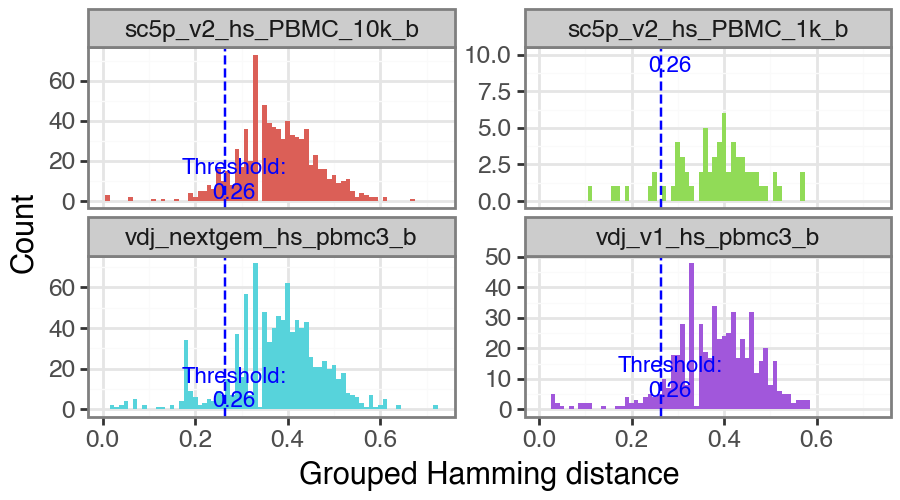

clone distance threshold: 0.26341158515509655


In [9]:
threshold = ddl.pp.calculate_threshold(vdj)
print(f"clone distance threshold: {threshold}")

You can also manually select a value as the threshold if you wish. Note that rerunning this with `manual_threshold` is just for reproducing the plot but with the line at 0.1 in this tutorial.

Calculating threshold


R[write to console]: Error in (function (db, sequenceColumn = "junction", vCallColumn = "v_call",  : 
  361 cell(s) with multiple heavy chains found. One heavy chain per cell is expected.



Rerun this after filtering. For now, switching to heavy mode.


R[write to console]: Running in non-single-cell mode.

/opt/homebrew/Caskroom/miniforge/base/envs/dandelion/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 956 rows containing non-finite values.


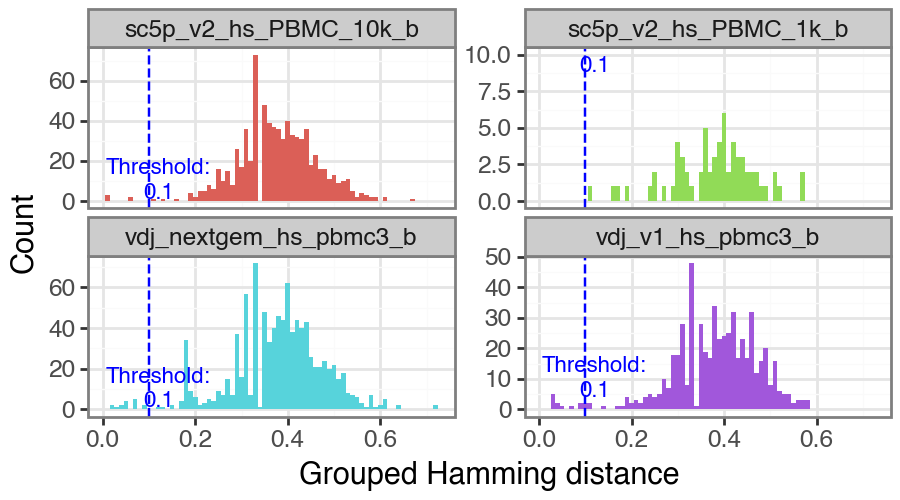

In [10]:
_ = ddl.pp.calculate_threshold(vdj, manual_threshold=0.1)


We can run `ddl.tl.define_clones` to call *changeo's* `DefineClones.py`; see [here](https://changeo.readthedocs.io/en/stable/methods/clustering.html) for more info. The value in dist option (corresponds to threshold value) needs to be manually supplied. Additional options for `ddl.tl.define_clones` to provide to `DefineClones.py` can be supplied as a list to the `additional_args` option.

In [11]:
# make a copy of the original vdj object to compare results
vdj_changeo = vdj.copy()
ddl.tl.define_clones(vdj_changeo, dist=threshold, key_added="changeo_clone_id")
vdj_changeo

Finding clones
Running command: DefineClones.py -d /var/folders/_r/j_8_fj3x28n2th3ch0ckn9c40000gt/T/tmpineapn33/tmp/dandelion_define_clones_heavy-clone.tsv -o /var/folders/_r/j_8_fj3x28n2th3ch0ckn9c40000gt/T/tmpineapn33/dandelion_define_clones_heavy-clone.tsv --act set --model ham --norm len --dist 0.26341158515509655 --nproc 1 --vf v_call_genotyped

       START> DefineClones
        FILE> dandelion_define_clones_heavy-clone.tsv
   SEQ_FIELD> junction
     V_FIELD> v_call_genotyped
     J_FIELD> j_call
 MAX_MISSING> 0
GROUP_FIELDS> None
      ACTION> set
        MODE> gene
    DISTANCE> 0.26341158515509655
     LINKAGE> single
       MODEL> ham
        NORM> len
         SYM> avg
       NPROC> 1

PROGRESS> [Grouping sequences] 16:43:51 (2177) 0.0 min

PROGRESS> [Assigning clones] 16:43:52 |####################| 100% (2,177) 0.0 min

 OUTPUT> dandelion_define_clones_heavy-clone.tsv
 CLONES> 2070
RECORDS> 2177
   PASS> 2177
   FAIL> 0
    END> DefineClones

 finished: Updated Dandelion 

Dandelion class object with n_obs = 2236 and n_contigs = 7355
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'c_call', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'consensus_count', 'umi_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'j_support_igblastn', 'j_score_igblastn', 'j_call_igblastn', 'j_call_blastn', 'j_identity_blastn', 'j_alignment_length_blastn', 

Note that I specified the parameter `key_added` and this adds the clone id output from `ddl.tl.define_clones` into a separate column. If left as default (`None`), it will write into `clone_id` column. The same `key_added` parameter can be specified in `ddl.tl.find_clones` earlier. You will notice that `vdj_changeo` is initisalised with `changeo_clone_id` as the first column while `vdj` has `clone_id` as the first.

## Other clustering methods
*dandelion* also now supports clustering methods from `scoper`. You can access the functions through:

```python
dandelion.external.immcancation.scoper.identical_clones(vdj, ...)
dandelion.external.immcancation.scoper.hierarchical_clones(vdj, ...)
dandelion.external.immcancation.scoper.spectral_clones(vdj, ...)
```

see the [dandelion documentation](https://sc-dandelion.readthedocs.io/en/latest/) and original [scoper documentation](https://scoper.readthedocs.io/en/latest/) for more details.

As more methods arise, we will continue  to evaluate which ones to include in *dandelion*. 


## Generation of V(D)J network
`dandelion` generates a network to facilitate visualisation of results, inspired from [[Bashford-Rogers2013]](https://genome.cshlp.org/content/23/11/1874). The deafult uses the full V(D)J contig amino acid sequences to chart a tree-like network for each clone, but it can also be used on any sequence columns, e.g. junctional nucleotide sequences. The actual visualization will be achieved through `scanpy` later.

### `ddl.tl.generate_network`

First we need to generate the network. `ddl.tl.generate_network` will take a V(D)J table that has clones defined, specifically under the `clone_id` column. The default mode is to use amino acid sequences for constructing Levenshtein distance matrices, but can be toggled using the `key` option, as well as other options for distance calculation, which will be covered in a separate tutorial later.

If you have a pre-processed table parsed from `immcantation`'s [method](https://changeo.readthedocs.io/en/stable/examples/10x.html), or any other method as long as it's in AIRR format, the table can be used as well.

You can specify the `clone_key` option for generating the network for the clone id definition of choice as long as it exists as a column in the `.data` slot.

In version 1.0.0 onwards, the method for distance calculation has been refactored to improve the speed. Prior to this, the distance matrix was always computed on a per chain basis and done sequentially as a loop over each chain. We have now vectorized the distance calculation to compute the distances for all chains at once while accounting for gaps, which should significantly speed up the process. There's also an option to use `n_cpus` to parallelize the computation across multiple cores, as well as the ability to supply a lambda function for custom distance calculation, or calculating BLOSUM-based distances. We will cover these options in more details in a later tutorial.

Before proceeding, let's do a bit of subsetting. Here I want to remove the `Orphan VJ` cells (lacking BCR heavy chain i.e. VDJ information). Whether or not you want to do this is up to you. I'm doing this because I want to focus on the BCR heavy chain for now. You may elect to keep everything and that can be your starting point for further analysis.

In [12]:
vdj = vdj[
    vdj.metadata.chain_status.isin(
        ["Single pair", "Extra pair", "Extra pair-exception", "Orphan VDJ"]
    )
].copy()
vdj

Dandelion class object with n_obs = 2111 and n_contigs = 5050
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'c_call', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'consensus_count', 'umi_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'j_support_igblastn', 'j_score_igblastn', 'j_call_igblastn', 'j_call_blastn', 'j_identity_blastn', 'j_alignment_length_blastn', 

In [13]:
ddl.tl.generate_network(vdj)

Generating network


Setting up data: 4422it [00:00, 8010.10it/s]


Calculating distance matrix  with distance_mode = 'clone'



100%|██████████| 2312/2312 [00:00<00:00, 15934.06it/s]

Distances calculated in 0.15 seconds



Linking edges : 100%|██████████| 2061/2061 [00:01<00:00, 2032.18it/s]


Generating network layout
To benefit from faster layout computation, please install graph-tool and use layout_method='sfdp': conda install -c conda-forge graph-tool
This message will only be shown once per session.
Computing network layout
Computing expanded network layout
 finished.
   Updated Dandelion object
:    'layout', graph layout
 (0:00:14)


In `dandelion` version `>=1.0.0`, the default `layout_method` is reverted back to `mod_fr` for personal aesthetics reasons. The alternative/faster option with `sfdp`, which is implemented through `graph-tool` [package](https://graph-tool.skewed.de/), is faster than the default modified Fruchterman-Reingold layout, but not as aesthetically pleasing for me.

The graph/networks can be accessed through the `.graph` slot as an [networkx](https://networkx.org/) graph object if you want to extract the data for network statistics or make any changes to the network.

```python
ddl.tl.generate_network(vdj, layout_method = 'mod_fr') # for the original
ddl.tl.generate_network(vdj, layout_method = 'sfdp') # for sfdp
```

<div class="alert alert-info">

Calculating distances without graph generation

If you only want to calculate the distances without generating the graph/layout, you can do:
<br>
```python
ddl.tl.generate_network(vdj, compute_graph = False)
```
<br>

Generating graph without layout

If you don't care for the layout and simply want access to the network/graph, you can do:
<br>
```python
ddl.tl.generate_network(vdj, compute_layout = False)
```
<br>
and use the networkx graphs in the graph slot and compute your own layout as you wish.

Regenerate graph and layout from existing distance matrices

As distance computation can be quite time consuming, if you have already computed the distance matrices and simply want to regenerate the graph and layout (for example, if you want to try a different layout method), you can do:
<br>
```python
ddl.tl.generate_network(vdj, use_existing_graph = False)
```
<br>

Parallel distance computation

If you want to speed up distance computation using multiple cores, you can do:
<br>
```python
ddl.tl.generate_network(vdj, n_cpus=8)
```
<br>


Calculating 'full' pairwise distance matrix

From version 1.0.0 onwards, if you want to calculate the full pairwise distance matrix for every pair of cells, you can do:
<br>
```python
ddl.tl.generate_network(vdj, distance_mode='full')
```
<br>

If you are dealing with large numbers of cells (>10k), you can take advantage of the new lazy evaluation feature to compute distances in chunks to reduce memory usage:
<br>
```python
ddl.tl.generate_network(vdj, distance_mode='full', lazy=True, n_cpus=8)
```
<br>
This will use `dask` to compute the distance matrix in chunks, storing the outputs as a `zarr` array on disk. Therefore, in order to use this feature, you need to have `dask`, `zarr` and `distributed` installed in your environment. You can specify the number of cores to use with `n_cpus` option, which would then trigger a parallel distributed job. Note that this may sometimes be slower than the default mode as there is some overhead with chunking and distribution, but it will allow you to compute distances for larger datasets without having to have the full matrix on memory. For more advance parameters on chunking and dask configuration, please refer to the API on our readthedocs or reach out and ask for help!
</div>

### Full pairwise distance computation

With version 1.0.0, we are bringing back the option to compute the full pairwise distance matrix for every pair of cells. This is useful if you want to have a more comprehensive view of the relationships between cells, rather than just within clones. However, this can be quite memory intensive, especially for large datasets. For that purpose, we have refactored the distance computation to allow for parallelization, as well as with lazy evaluation using `dask` and `zarr` arrays, which allows for handling larger datasets without running into memory issues. This is particularly useful when calculating the full pairwise distance matrix for every pair of cells, which can be quite memory-intensive. While this can also be used for `distance_mode='clone'`, it's incredibly slow. Its main advantage is for `distance_mode='full'` due to contigous nature of the distance matrix.

Note that with `distance_mode='full'`, the required memory scales quadratically with the number of cells, so be cautious when using this option with large datasets. Using `dask` and `zarr` arrays can help mitigate this issue by allowing for out-of-core computation and parallel processing. This will create a `zarr` array on disk to store the distance matrix, which can later be read into memory in the `dandelion` object with `vdj.compute()`, or specifying the path to the `zarr` array when reading the `Dandelion` object with `ddl.read_h5ddl`.

Finally, while pairwise distance computation is now possible, the final graph and layout is still based on within-clone distances only for performance reasons i.e. it will behave as before. In the future, we may explore options to incorporate full pairwise distances into the graph construction and visualization. We will demonstrate alternative ways to visualise the full pairwise distances in a later tutorial where use use `UMAP` and `wnn` on the full distance matrix.

To be able to use `lazy=True`, you need to have `dask`, `zarr` and `distributed` installed in your environment.

```bash
pip install "sc-dandelion[dask]"
```

In [14]:
# we will demonstrate one example here where we use the lazy method to compute the network
vdj_lazy = vdj.copy()
ddl.tl.generate_network(
    vdj_lazy,
    use_existing_graph=False,
    distance_mode="full",
    lazy=True,
    n_cpus=8,
    zarr_path="distance_matrix.zarr",  # this is where the final computed distance matrix will be stored on disk
)

Generating network


Setting up data: 4422it [00:00, 8075.31it/s]

Calculating distance matrix lazily with distance_mode = 'full'

Auto computation chunk size: 2111 sequences per block
Estimated memory per block: 0.03 GB
Zarr storage chunk size: 2111
Output size: 0.03 GB uncompressed



Created Zarr array at: distance_matrix.zarr
Compressor: BloscCodec(typesize=None, cname=<BloscCname.zstd: 'zstd'>, clevel=3, shuffle=<BloscShuffle.bitshuffle: 'bitshuffle'>, blocksize=0)



/opt/homebrew/Caskroom/miniforge/base/envs/dandelion/lib/python3.11/site-packages/distributed/node.py:188: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 65132 instead


Dask client started: http://127.0.0.1:65132/status
Setting up Dask scheduler and task graph...
Starting computation of 36 chunks...
Merging temporary results into final Zarr array...


100%|██████████| 36/36 [00:05<00:00,  6.17it/s]




✓ Distance matrix complete!

Final array info:
  Shape: (2111, 2111)
  Dtype: float64
  Chunks: (2111, 2111)
  Size on disk: 0.03 GB uncompressed
  Actual size: 0.00 GB (with compression)
  Compression ratio: 7.3x


Linking edges : 100%|██████████| 2061/2061 [00:01<00:00, 1849.05it/s]


Generating network layout
Computing network layout
Computing expanded network layout
 finished.
   Updated Dandelion object
:    'layout', graph layout
 (0:02:38)


In [15]:
# view the vdj object
vdj_lazy

Dandelion class object with n_obs = 2111 and n_contigs = 5050
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'c_call', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'consensus_count', 'umi_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'j_support_igblastn', 'j_score_igblastn', 'j_call_igblastn', 'j_call_blastn', 'j_identity_blastn', 'j_alignment_length_blastn', 

In [16]:
# save as well
vdj_lazy.write_h5ddl(
    "dandelion_results_lazy_distance_matrix.h5ddl", compression="gzip"
)

Because the distance matrix is lazy, it is not stored in the `h5ddl` file, but rather as the separate zarr array on disk in `zarr_path`. We will show you how to read this back in later.

### Caveats with lazy distance matrix computation

With `lazy=True`, the distance matrix computation will be performed lazily on disk, which allows for handling larger datasets without running into memory issues. This is particularly useful when calculating the full pairwise distance matrix for every pair of cells, which can be quite memory-intensive.

While this can also be used for `distance_mode='clone'`, it's incredibly slow. Its main advantage is for `distance_mode='full'` due to contigous nature of the distance matrix.

The `.distances` slot will now contain a `dask` array instead of a compressed sparse matrix. You can compute the distance matrix into memory by calling `vdj.compute()`.

In [17]:
# examine the .distances slot
vdj_lazy.distances

dask.array<from-zarr, shape=(2111, 2111), dtype=float64, chunksize=(2111, 2111), chunktype=numpy.ndarray>

In [18]:
# read distance matrix into memory
vdj_lazy.compute()
# now the distance matrix is in memory as a compressed sparse matrix
vdj_lazy.distances

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 4456067 stored elements and shape (2111, 2111)>

At this point, we can save the dandelion object. We will visualise the network in the next tutorial.

In [19]:
vdj.write_h5ddl("dandelion_results_simplified.h5ddl", compression="gzip")

In [20]:
# let's also transfer the new slots to the original files
vdj_original = ddl.read_h5ddl("dandelion_results.h5ddl")
vdj_original

Dandelion class object with n_obs = 2236 and n_contigs = 7355
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'c_call', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'consensus_count', 'umi_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'j_support_igblastn', 'j_score_igblastn', 'j_call_igblastn', 'j_call_blastn', 'j_identity_blastn', 'j_alignment_length_blastn', 

In [21]:
vdj_original.metadata = vdj.metadata.copy()
vdj_original.layout = vdj.layout
vdj_original.graph = vdj.graph
vdj_original

Dandelion class object with n_obs = 2236 and n_contigs = 7355
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'c_call', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'consensus_count', 'umi_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'j_support_igblastn', 'j_score_igblastn', 'j_call_igblastn', 'j_call_blastn', 'j_identity_blastn', 'j_alignment_length_blastn', 

In [22]:
# save
vdj_original.write_h5ddl("dandelion_results.h5ddl", compression="gzip")

Finally, this is how you can read a `dandelion` object saved with lazy distance matrix computation. The distance matrix will still be a `zarr` array on disk, which you can compute into memory with `vdj.compute()` when needed.

In [23]:
vdj_lazy_reload = ddl.read_h5ddl(
    "dandelion_results_lazy_distance_matrix.h5ddl",
    distance_zarr="distance_matrix.zarr",
)
vdj_lazy_reload

Dandelion class object with n_obs = 2111 and n_contigs = 5050
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'c_call', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'consensus_count', 'umi_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'j_support_igblastn', 'j_score_igblastn', 'j_call_igblastn', 'j_call_blastn', 'j_identity_blastn', 'j_alignment_length_blastn', 

In [24]:
vdj_lazy_reload.compute()
vdj_lazy_reload

Dandelion class object with n_obs = 2111 and n_contigs = 5050
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'c_call', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'consensus_count', 'umi_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'j_support_igblastn', 'j_score_igblastn', 'j_call_igblastn', 'j_call_blastn', 'j_identity_blastn', 'j_alignment_length_blastn', 

In [25]:
vdj_lazy_reload.distances

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 4456067 stored elements and shape (2111, 2111)>